In [2]:
parent_path='../Data/New_Data_15-06-2020/'
%load_ext autoreload
%autoreload 2
import parmap
import pandas as pd
from tqdm import tqdm,tqdm_notebook
from utils.marking_similars import *
from utils.preprocess import *
from utils.emoji_extract import *
from utils.visualisation import latex_emoji_communities
import matplotlib.pyplot as plt
import empath
import seaborn as sns
from empath import Empath
import networkx as nx
import matplotlib
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

lexicon = Empath()
dict_map={0:'non fear speech',1:'fear speech'}

def get_empath_categories(df,normalize=False): 
    tuples=[]
    for index,row in tqdm(df.iterrows(),total=len(df)):
        dict_lexicon=lexicon.analyze(row['translated'], normalize=normalize)
        try:
            temp=dict_lexicon.values()
        except AttributeError:
            dict_lexicon=lexicon.analyze("sample text", normalize=normalize)
        temp=list(dict_lexicon.values())+[index,dict_map[row['one_fear_speech']]]
        tuples.append(temp)
    df_empath=pd.DataFrame(tuples,columns=list(dict_lexicon.keys())+['org_index','label'])
    
    
    print(len(df),len(df_empath))
    df=df.reset_index(drop=True)
    #df_with_empath=pd.concat([df,df_empath],axis=1)
    return df_empath


In [4]:
annotated_df=pd.read_pickle(parent_path+'Fearspeech_data_final.pkl')

100%|██████████| 4782/4782 [00:50<00:00, 94.67it/s] 


4782 4782


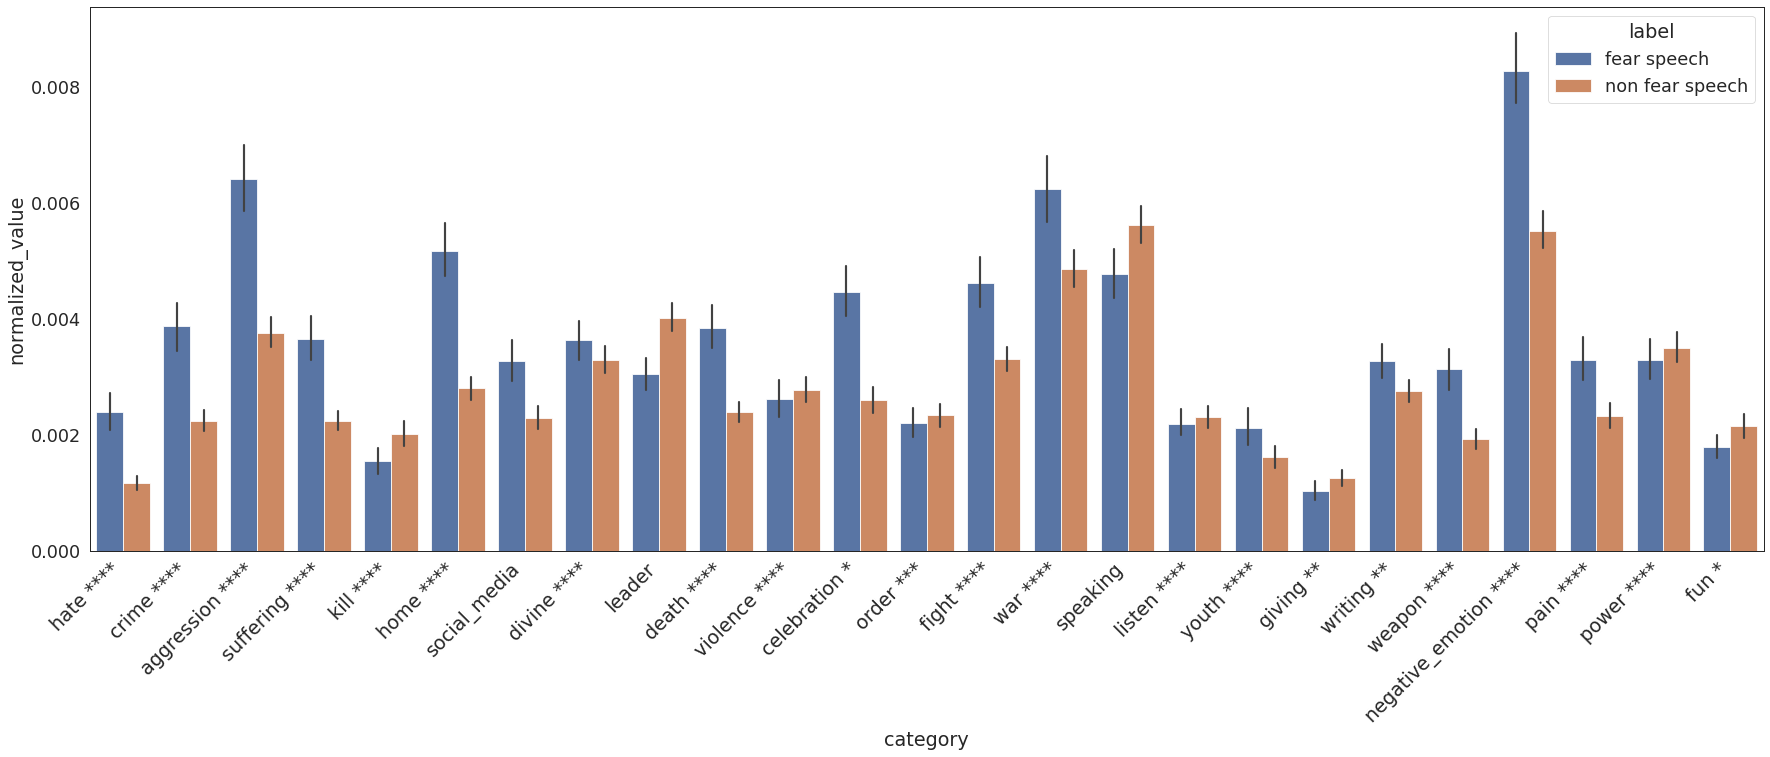

In [5]:
annotated_df_empath=get_empath_categories(annotated_df,normalize=True)

annotated_df_empath = pd.melt(annotated_df_empath,id_vars="label",var_name="category", value_name="normalized_value")
annotated_df_empath=annotated_df_empath[annotated_df_empath['category']!='org_index']
annotated_df_empath.head()
#categories=['help', 'cold', 'hate', 'cheerfulness', 'aggression', 'occupation', 'envy', 'family', 'crime', 'masculine', 'pride', 'dispute', 'government', 'weakness', 'horror', 'swearing_terms', 'leisure', 'suffering', 'royalty', 'wealthy', 'tourism', 'journalism', 'social_media', 'kill', 'ridicule', 'stealing', 'real_estate', 'home', 'divine', 'sexual', 'fear', 'irritability', 'religion', 'worship', 'leader', 'independence', 'movement', 'medieval', 'death', 'legend', 'heroic', 'celebration', 'violence', 'military', 'neglect', 'love', 'order', 'sympathy', 'anonymity', 'trust', 'ancient', 'deception', 'fight', 'dominant_personality', 'politeness', 'war', 'speaking', 'listen', 'disgust', 'fire', 'gain', 'injury', 'rage', 'work', 'valuable', 'warmth', 'youth', 'sadness', 'fun', 'emotional', 'joy', 'affection', 'ugliness', 'lust', 'shame', 'torment', 'anger', 'politics', 'strength', 'technology', 'breaking', 'power', 'animal', 'terrorism', 'disappointment', 'pain', 'philosophy', 'negotiate', 'negative_emotion', 'competing', 'law', 'friends', 'achievement', 'feminine', 'weapon', 'monster', 'giving', 'contentment', 'writing', 'positive_emotion']
categories=["hate", "crime", "aggression", "suffering", "kill", "home", "social_media", "divine", "leader", "death", "violence", "celebration", "order", "fight", "war", "speaking", "listen", "youth", "giving", "writing", "weapon", "negative_emotion", "pain", "power", "fun"]


matplotlib.rcParams['figure.figsize'] = (30,10)

sns.set(context='paper',style='white',font_scale=1.5)

temp=annotated_df_empath[annotated_df_empath['category'].isin(categories)]
font = {
    'weight' : 'normal',
    'size'   : 11}

sns.set(context='paper',style='white',font_scale=2.0)

g = sns.barplot(x="category", y="normalized_value",hue="label",data=temp)
#g=add_values(g,df_admin,15,order_list)
#plt.ylabel('number of groups as admin')
g.set_xticklabels(
        g.get_xticklabels(), 
        rotation=45, 
        horizontalalignment='right',
        fontweight='normal',
        fontsize='medium'

    )

xlist_label=[]

for cat in categories:
    temp=annotated_df_empath[annotated_df_empath['category']==cat]
    treatment=np.array(temp[temp['label']=='fear speech'].normalized_value)
    control=np.array(temp[temp['label']=='non fear speech'].normalized_value)
    seed(2)
    # generate two independent samples
    # compare samples
    stat, p = mannwhitneyu(treatment, control)
    
    if(p<=0.00001):
        cat=cat+" ****"
    elif(p<=0.0001):
        cat=cat+" ***"
    elif(p<=0.001):
        cat=cat+" **"
    elif(p<0.01):
        cat=cat+" *"
    xlist_label.append(cat)

plt.xticks(ticks=range(0,25),labels=xlist_label)

    
# plt.show()
plt.savefig('../Fear_speech_results/empath.pdf',bbox_inches='tight',dpi=400)

In [6]:
# fear_speech_df=annotated_df[annotated_df['one_fear_speech']==1]
# non_fear_speech_df=annotated_df[annotated_df['one_fear_speech']==0]

# test_heldout_fs=fear_speech_df.sample(500,random_state=2020)
# test_heldout_nfs=non_fear_speech_df.sample(500,random_state=2020)

# gold_train_fs=fear_speech_df.drop(test_heldout_fs.index)
# gold_train_nfs=non_fear_speech_df.drop(test_heldout_nfs.index)

# gold_train=pd.concat([gold_train_fs,gold_train_nfs])
# test_heldout=pd.concat([test_heldout_fs,test_heldout_nfs])
 
# gold_train.to_csv(parent_path+'gold_labels.csv',index=False)
# test_heldout.to_csv(parent_path+'test_heldout.csv',index=False)

In [7]:
import readability
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()


In [8]:
tuples_list=[]
dict_map={0:'non fear speech',1:'fear speech'}


for index,row in tqdm(annotated_df.iterrows(),total=annotated_df.shape[0]):
    tokens=preprocess_sent(row["message_text"],params={'remove_numbers': True, 'remove_emoji': True, 'remove_stop_words': False, 'tokenize': True})
    token_lengths = [len(token) for token in tokens]
    length_distribution = nltk.FreqDist(token_lengths)
    for token in length_distribution:
        tuples_list.append([token,length_distribution[token],dict_map[row['one_fear_speech']]])
    

100%|██████████| 4782/4782 [01:01<00:00, 78.18it/s] 


In [9]:
df_token_length=pd.DataFrame(tuples_list,columns=['length','number of docs','label'])

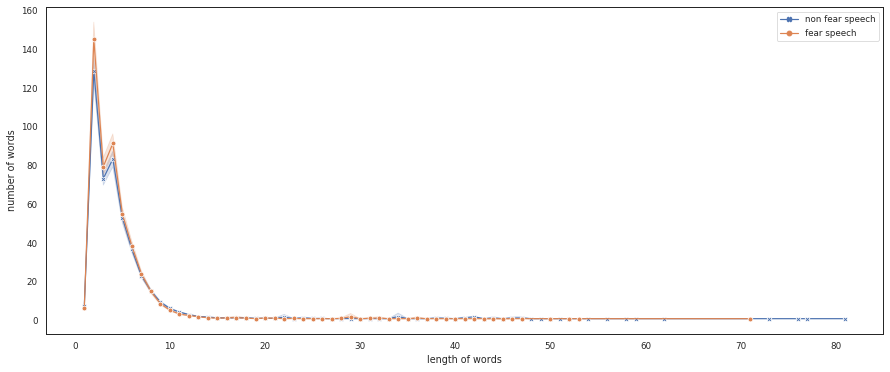

In [10]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 6)
# font = {
#     'weight' : 'normal',
#     'size'   : 15}
# matplotlib.rc('font', **font)
#data_timeline.plot()
sns.set(context='paper',style='white',font_scale=1.0)
window=7
ax = sns.lineplot(x="length", y="number of docs",hue="label",style="label",data=df_token_length,hue_order=dict_map.values(),markers=True,dashes=False,estimator=np.mean)
plt.xlabel('length of words')
plt.ylabel('number of words')
plt.legend()
#plt.yscale('log')
#plt.savefig('Results/Whatsapp_usage_of_keywords.jpg',bbox_inches='tight',dpi=400)
plt.show() 

In [11]:
edges={}
emoji_dict={}
emoji_dict_count={}
emoji_dict_reverse={}
window=5


count=0
for index,row in tqdm_notebook(annotated_df[annotated_df['one_fear_speech']==1].iterrows(),total=len(annotated_df[annotated_df['one_fear_speech']==1])):
    emojis_with_index=extract_emojis_index(row['message_text'])
    
    
    for ele in emojis_with_index:
        try:
            emoji_dict_count[ele[1]]+=1
        except KeyError:
            emoji_dict_count[ele[1]]=1
    
    
    for i in range(len(emojis_with_index)):
        ele1=emojis_with_index[i]
        for j in range(i,len(emojis_with_index)):
            ele2=emojis_with_index[j]
            
            try:
                temp1=emoji_dict[ele1[1]]
            except:
                count+=1
                emoji_dict[ele1[1]]=count
                emoji_dict_reverse[count]=ele1[1]
                temp1=count
            
            try:
                temp2=emoji_dict[ele2[1]]
            except:
                count+=1
                emoji_dict[ele2[1]]=count
                emoji_dict_reverse[count]=ele2[1]
                temp2=count
            
            if(temp1<temp2):
                key_adj=str(temp1)+'--'+str(temp2)
            elif(temp2<temp1):
                key_adj=str(temp2)+'--'+str(temp1)
            else:  
                continue
            try:
#                 edges[key_adj][0]+=abs(ele1[0]-ele2[0])
#                 edges[key_adj][1]+=1
                if(abs(ele1[0]-ele2[0]) <window):
                    edges[key_adj]+=1


            except KeyError:
#                 edges[key_adj]=[abs(ele1[0]-ele2[0]),1]
                 if(abs(ele1[0]-ele2[0])<window):
                    
                    edges[key_adj]=1
            

/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [12]:
inv_map = {v: k for k, v in emoji_dict.items()}


In [13]:
emoji_stop=['☝','✌', '▪','🏼','🏻','🏿','🏾','🏽','➖','🔽','🇴','🇧','⚜','☘', '☕', '♦','▪','‼','♻','🇪','🇺','🇮', '🇳','🇲', '🇷', '🇸', '🇦', '🇵', '🇰', '🇨']
edge_list=[]

for key in edges.keys():
    ele1=int(key.split('--')[0])
    ele2=int(key.split('--')[1])
    if(emoji_dict_count[inv_map[ele1]]<10 or emoji_dict_count[inv_map[ele2]]<10 or inv_map[ele1] in emoji_stop or inv_map[ele2] in emoji_stop):
        continue
        
    avg_distance= edges[key]/(emoji_dict_count[inv_map[ele1]]*emoji_dict_count[inv_map[ele2]])
    edge_list.append([ele1,ele2,avg_distance])

In [14]:
G = nx.Graph()


In [15]:
G.add_weighted_edges_from(edge_list)

In [16]:
len(G.nodes())

98

In [17]:
import community as community_louvain
import networkx as nx
partion = community_louvain.best_partition(G)

In [18]:
partion

{1: 0,
 2: 0,
 3: 1,
 4: 2,
 10: 2,
 11: 3,
 12: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 24: 4,
 25: 4,
 26: 4,
 27: 1,
 31: 2,
 33: 0,
 36: 1,
 37: 1,
 20: 1,
 38: 2,
 39: 2,
 40: 2,
 41: 0,
 42: 5,
 43: 5,
 44: 5,
 45: 5,
 23: 0,
 52: 2,
 58: 0,
 59: 0,
 60: 0,
 61: 2,
 62: 0,
 63: 6,
 64: 6,
 67: 6,
 69: 0,
 80: 0,
 81: 0,
 97: 1,
 106: 0,
 118: 6,
 34: 4,
 22: 6,
 121: 6,
 123: 7,
 124: 7,
 109: 7,
 126: 6,
 48: 8,
 54: 8,
 92: 0,
 138: 1,
 140: 3,
 141: 3,
 146: 4,
 148: 0,
 155: 3,
 160: 1,
 165: 4,
 180: 6,
 181: 3,
 95: 6,
 168: 1,
 78: 0,
 82: 1,
 183: 5,
 96: 6,
 134: 0,
 50: 1,
 6: 1,
 184: 5,
 101: 4,
 198: 4,
 51: 4,
 204: 4,
 133: 2,
 176: 1,
 202: 5,
 215: 6,
 174: 4,
 220: 5,
 169: 0,
 65: 6,
 249: 8,
 272: 6,
 132: 0,
 235: 1,
 247: 6,
 139: 1,
 194: 0,
 320: 6,
 330: 0,
 331: 0,
 335: 1,
 98: 3}

In [19]:
partition_emoji={}
for key in partion:
    emoji=emoji_dict_reverse[key]
    try:
        partition_emoji[partion[key]].append(emoji)
    except KeyError:
        partition_emoji[partion[key]]=[emoji]

In [36]:
for key in partition_emoji:
    print(partition_emoji[key])

['✊', '🚩', '🙏', '🔱', '🏹', '🐚', '🕉', '⛳', '😢', '👆', '🔥', '🌞', '👊', '🐆', '🌹', '🌼', '😊', '🍁', '✅', '🌷', '❗', '🤝', '💐', '🗣', '👍', '〰', '⏺']
['😎', '👺', '📗', '✍', '👉', '❓', '❌', '😈', '⭕', '👿', '🐷', '🐖', '🕋', '🌀', '📌', '🔰']
['💣', '🔫', '🗡', '⚔', '🤺', '🦁', '💥', '🐅', '☪']
['😡', '⚫', '🛑', '🔵', '✋', '⬇']
['👹', '🤷', '♂', '😞', '🧐', '💁', '♀', '🧝', '⁉', '🤨', '🤫']
['😭', '📱', '📲', '✔', '💪', '👏', '😰', '😬']
['🤔', '😏', '😔', '😠', '👇', '🔺', '🎀', '☹', '😱', '👈', '📖', '😳', '🌐', '😤', '➡']
['😀', '😁', '😂']
['📚', '✒', '🖌']


In [50]:
temp=latex_emoji_communities(partition_emoji)
with open("Output.txt", "w") as text_file:
    print(temp, file=text_file)

#### Topic analysis



In [53]:
from gensim.models.ldamodel import LdaModel
import gensim


def handler_funtion(data):
    processed_words=list(data['tokenized'])
    dictionary = gensim.corpora.Dictionary(processed_words)
    dictionary.filter_extremes(no_below=3, no_above=0.5, keep_n=50000)
    list_docs=[]
    for index,row in tqdm_notebook(data.iterrows(),total=len(data)):
        list_docs.append(dictionary.doc2bow(row['tokenized']))
    idxtoken={k:v for v,k in dictionary.token2id.items()}
    return dictionary,idxtoken,list_docs

def get_topic(time_filtered_data,num_topics=10):
    '''make sure to have the time as a tuple (year,month,day,hr,min,sec) and the data is a dataframe'''
    '''to channge the model parameters change it in 09_topicmodeling.ipynb'''
    print(len(time_filtered_data))    
    params={'remove_numbers':True,'remove_emoji':False,'remove_stop_words':True,'tokenize':True}
    token_list=[preprocess_sent(ele,params) for ele in tqdm_notebook(list(time_filtered_data['message_text']),total=len(time_filtered_data))]    
    time_filtered_data['tokenized']=token_list
    dictionary,idxtoken,list_docs= handler_funtion(time_filtered_data)
    time_filtered_data['topic']=-1
    
    #lda=LatentDirichletAllocation(n_components=num_topics,n_jobs=-1,max_iter=20,evaluate_every=1)
    lda = LdaModel(list_docs, id2word=idxtoken, num_topics=num_topics,chunksize=100,passes=20)
    #lda.fit(dense_vector)
    topic_list=[]
    lda_topics=lda.show_topics(num_topics=num_topics,formatted = False,num_words=15)

    for index, topic in enumerate(lda_topics):
        topic=topic[1]
        topic_list.append([ele[0] for ele in topic])
    for index,row in tqdm_notebook(time_filtered_data.iterrows(),total=len(time_filtered_data)):
        #topic_vector=lda.transform(dense_vector[i].reshape(1,-1))
        #print(row['tokenized'])
        try:
            vector=lda[dictionary.doc2bow(row['tokenized'])]
            vector=[ele[1] for ele in vector]
            time_filtered_data.at[index,'topic']=np.argmax(vector)
        except:
            time_filtered_data.at[index,'topic']=0
    return time_filtered_data,lda_topics

In [54]:
time_filtered_data,topic_list=get_topic(annotated_df[annotated_df['one_fear_speech']==1],num_topics=5)

1142


/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [71]:
lexicon_path='../Data/Important_lexicon/'
########################################
def get_lexicon(type1,path):
    lexicon=[]
    with open(path+type1+'_keywords_complete.txt', 'r') as f:
        temp=f.read().splitlines()
    for word in temp:
        lexicon.append(word)
    return lexicon

muslim_lexicon=get_lexicon('muslim',lexicon_path)
hindu_lexicon=get_lexicon('hindu',lexicon_path)

In [90]:
fear_speech_unique=annotated_df[annotated_df['one_fear_speech']==1]
params={'remove_numbers':True,'remove_emoji':False,'remove_stop_words':True,'tokenize':True}


list_preprocessed=[]
for ele in tqdm(fear_speech_unique['message_text']):
    temp=preprocess_sent(ele,params)
    temp_new=[]
    for word in temp:
        if(word not in muslim_lexicon):
            temp_new.append(word) 
    list_preprocessed.append(temp_new)
fear_speech_unique['preprocessed']=list_preprocessed


100%|██████████| 1142/1142 [00:25<00:00, 44.50it/s]
/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [97]:
import gensim

data_words = fear_speech_unique.preprocessed.values.tolist()

bigram = gensim.models.Phrases(data_words, min_count=2, threshold=3) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=3)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [98]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words)

In [99]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [ ]:
from gensim.models import CoherenceModel


# Build LDA model
coherence_list=[]
for numtopics in tqdm_notebook(range(2,40)):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=numtopics, 
                                               random_state=100,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True)

        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_list.append(coherence_lda)

/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [107]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=22, 
                                               random_state=100,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True)

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()


Process ForkPoolWorker-2443:
Process ForkPoolWorker-2431:
Process ForkPoolWorker-2401:
Process ForkPoolWorker-2412:
Process ForkPoolWorker-2444:
Process ForkPoolWorker-2424:
Process ForkPoolWorker-2434:
Process ForkPoolWorker-2425:
Process ForkPoolWorker-2437:
Process ForkPoolWorker-2442:
Process ForkPoolWorker-2413:
Process ForkPoolWorker-2406:
Process ForkPoolWorker-2436:
Process ForkPoolWorker-2432:
Process ForkPoolWorker-2439:
Process ForkPoolWorker-2398:
Process ForkPoolWorker-2428:
Process ForkPoolWorker-2440:
Process ForkPoolWorker-2429:
Process ForkPoolWorker-2435:
Process ForkPoolWorker-2400:
Process ForkPoolWorker-2407:
Process ForkPoolWorker-2414:
Process ForkPoolWorker-2402:
Process ForkPoolWorker-2404:
Process ForkPoolWorker-2399:
Process ForkPoolWorker-2415:
Process ForkPoolWorker-2405:
Process ForkPoolWorker-2430:
Process ForkPoolWorker-2421:
Process ForkPoolWorker-2417:
Process ForkPoolWorker-2420:
Process ForkPoolWorker-2426:
Process ForkPoolWorker-2441:
Process ForkPo

  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/punyajo

  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/pool.py", line 105, in worker

  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, 

KeyboardInterrupt
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/punyajoy/.conda/envs/pu

  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
Traceback (most recent call last):
KeyboardInterrupt
KeyboardInterrupt
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/punya

KeyboardInterrupt: 

  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/pool.py", line 105, in worker
    initializer(*initargs)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/gensim/models/ldamulticore.py", line 334, in worker_e_step
    chunk_no, chunk, worker_lda = input_queue.get()
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/multiprocessing/connection.py

In [ ]:
coherence_lda

In [95]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(num_words=15))
doc_lda = lda_model[corpus]

[(0,
  '0.004*"भारत" + 0.003*"हिन्दू" + 0.002*"देश" + 0.002*"कभी" + 0.002*"आज" + '
  '0.002*"लोग" + 0.001*"कश्मीर" + 0.001*"ज्यादा" + 0.001*"जाता" + 0.001*"होगा" '
  '+ 0.001*"बात" + 0.001*"केवल" + 0.001*"पाकिस्तान" + 0.001*"सिर्फ" + '
  '0.001*"हिंदुओं"'),
 (1,
  '0.006*"भारत" + 0.004*"हिन्दू" + 0.003*"देश" + 0.003*"लोगों" + '
  '0.003*"पाकिस्तान" + 0.003*"लोग" + 0.003*"triangular_flag" + 0.002*"नाम" + '
  '0.002*"आज" + 0.002*"मंदिर" + 0.002*"जाता" + 0.002*"अगर" + 0.002*"रही" + '
  '0.002*"heavy_minus_sign_heavy_minus_sign" + 0.002*"कांग्रेस"'),
 (2,
  '0.005*"हिन्दू" + 0.004*"भारत" + 0.003*"देश" + 0.002*"नाम" + '
  '0.002*"triangular_flag" + 0.002*"अगर" + 0.001*"बात" + 0.001*"आज" + '
  '0.001*"लोग" + 0.001*"सब" + 0.001*"बम_धमाके" + 0.001*"हिन्दुओं" + '
  '0.001*"करके" + 0.001*"तुम" + 0.001*"हिन्दुओ"'),
 (3,
  '0.002*"लड़की" + 0.002*"books_books" + 0.002*"पाकिस्तान" + 0.002*"देश" + '
  '0.002*"हिन्दू" + 0.002*"मेवात" + 0.002*"लड़की" + 0.002*"right_arrow" + '
  '0.001*"जाता" + 0.001*"सम

In [96]:

print('Coherence Score: ', coherence_lda)

Coherence Score:  0.41437980554943965


###  use of postags

In [ ]:
import stanza

In [ ]:
stanza.download('hi') # download English model
nlp = stanza.Pipeline('en',use_gpu=False) # initialize English neural pipeline
doc = nlp("Barack Obama was born in Hawaii.He was a cool kid") # run annotation over a sentence

In [ ]:
annotated_df.columns

In [ ]:
tuple_dict={}
tuple_list_final={}


nlp_hindi=nlp = stanza.Pipeline('hi',use_gpu=False) # initialize English neural pipeline
nlp_english=nlp = stanza.Pipeline('en',use_gpu=False) # initialize English neural pipeline




for index,row in tqdm_notebook(annotated_df[annotated_df['one_fear_speech']==1].iterrows(),total=len(annotated_df[annotated_df['one_fear_speech']==1])):
#     nlp = stanza.Pipeline(row['language'],use_gpu=False) # initialize English neural pipeline
    if(row['language']!='en'):
        nlp=nlp_hindi
    else:
        nlp=nlp_english
    params={'remove_numbers':True,'remove_emoji':True,'remove_stop_words':True,'tokenize':False}
    preprocess_sent_temp=preprocess_sent(row['message_text'],params)
    doc = nlp(preprocess_sent_temp) 
    temp = {}
    tuple_list_final[index]=doc.to_dict()
    for element in doc.to_dict():
        for ele in element:
            if(ele['upos'] in ['PROPN']):
                try:
                    temp[ele['upos']]+=1
                except KeyError:
                    temp[ele['upos']]=1
    tuple_dict[index]=temp

In [ ]:
import pickle


with open(parent_path+'stanza_run.pickle', 'wb') as handle:
    pickle.dump(tuple_list_final, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pandas as pd

object = pd.read_pickle(parent_path+'stanza_run.pickle')

In [ ]:
tuple_dict={}

for key in tuple_list_final.keys():
    doc=tuple_list_final[key]
    temp = {}
    for element in doc:
        for ele in element:
            if(ele['upos'] in ['NOUN']):
                try:
                    try:
                        print(int(ele['text']))
                    except ValueError:
                        temp[ele['text']]+=1
                except KeyError:
                    try:
                        print(int(ele['text']))
                    except ValueError:
                        temp[ele['text']]=1
                    
    tuple_dict[key]=temp



In [ ]:
tuple_list_corpus=[]
for key in tuple_dict:
    for ele in tuple_dict[key]:
        
        tuple_list_corpus.append([key,ele,tuple_dict[key][ele]])

In [ ]:
df=pd.DataFrame(tuple_list_corpus,columns=['label','term','n'])

In [ ]:
df=df.set_index(['label'],drop=True)

df

In [ ]:
from textnets import Corpus, Textnet

In [ ]:
tn = Textnet(df, min_docs=5)

In [ ]:
tn.top_closeness(100)

In [ ]:
import shifterator as sh

def dict_freq(df):
    dict_fear_speech={}
    dict_normal={}
    for index,row in tqdm_notebook(df.iterrows(),total=len(df)):
        params={'remove_numbers':True,'remove_emoji':True,'remove_stop_words':True,'tokenize':True}
        preprocess_sent_temp=preprocess_sent(row['translated'],params)
        if(row['one_fear_speech']==1):
            for ele in preprocess_sent_temp:
                try:
                    dict_fear_speech[ele]+=1
                except KeyError:
                    dict_fear_speech[ele]=1
        if(row['one_fear_speech']==0):
            for ele in preprocess_sent_temp:
                try:
                    dict_normal[ele]+=1
                except KeyError:
                    dict_normal[ele]=1
    return dict_fear_speech, dict_normal
    








dict_fear_speech, dict_normal=dict_freq(annotated_df)

In [ ]:
proportion_shift = sh.EntropyShift(type2freq_1=dict_fear_speech,
                                      type2freq_2=dict_normal,base=2)
proportion_shift.get_shift_graph(system_names = ['Fear speech', 'Non Fear speech'],
                                 title='Entropy shift of Fear speech posts',top_n=50)

In [ ]:
from googlesearch import search,get_tbs

In [ ]:
i=10
print(fear_speech_unique.iloc[i]['translated'])
for url in search(fear_speech_unique.iloc[i]['translated'][0:4000], stop=100):
    print(url)

In [ ]:
from datetime import datetime


In [ ]:
fear_speech_unique=annotated_df[annotated_df['one_fear_speech']==1]


In [ ]:
fear_speech_unique.iloc[0]['message_text']